# Imbalanced datasets
------------------------------------

This example shows how ATOM can help you handle imbalanced datasets. We will evaluate the performance of three different Random Forest models: one trained directly on the imbalanced dataset, one trained on an oversampled dataset and the last one trained on an undersampled dataset.

## Load the data

In [1]:
# Import packages
from atom import ATOMClassifier
from sklearn.datasets import make_classification

In [2]:
# Create a mock imbalanced dataset
X, y = make_classification(
    n_samples=5000,
    n_features=30,
    n_informative=20,
    weights=(0.95,),
    random_state=1,
)

## Run the pipeline

In [3]:
# Initialize atom
atom = ATOMClassifier(X, y, test_size=0.2, verbose=2, random_state=1)

<< ================== ATOM ================== >>
Algorithm task: binary classification.

Dataset stats ==================== >>
Shape: (5000, 31)
Scaled: False
Outlier values: 582 (0.5%)
-------------------------------------
Train set size: 4000
Test set size: 1000
-------------------------------------
|    |      dataset |        train |         test |
| -- | ------------ | ------------ | ------------ |
| 0  |  4731 (17.6) |  3777 (16.9) |   954 (20.7) |
| 1  |    269 (1.0) |    223 (1.0) |     46 (1.0) |



In [4]:
# Let's have a look at the data. Note that, since the input wasn't
# a dataframe, atom has given default names to the columns.
atom.head()

,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9,Feature 10,...,Feature 22,Feature 23,Feature 24,Feature 25,Feature 26,Feature 27,Feature 28,Feature 29,Feature 30,target
0,-3.487515,3.854686,-0.540999,14.601416,2.656621,0.890481,-1.369840,-4.366444,3.466322,-0.029618,...,0.404926,1.743085,7.313850,-0.922566,0.994747,0.000604,-1.441929,-0.741606,-1.021307,0
1,0.493415,-5.068825,0.727330,5.470114,1.631227,-1.267924,0.550369,-2.055318,-0.105617,3.511867,...,2.888285,0.309113,3.817221,1.118588,1.502536,-0.143976,-1.250787,6.095970,0.490575,0
2,0.010148,-1.926452,-2.079807,-3.113497,4.962937,1.586091,-0.201393,-3.469079,5.401403,5.751620,...,5.692868,-2.097011,-7.173968,-0.493898,-3.530642,-1.061223,5.956756,3.937707,2.394163,0
3,1.134321,4.081801,0.012246,7.176998,-2.520901,-3.982497,-1.034924,0.885346,2.221092,-1.082554,...,-4.747836,-0.642487,6.538375,-0.724994,-3.191186,-0.220013,1.133145,-0.385503,1.351542,0
4,1.324943,1.428477,0.935775,1.270190,-2.449393,1.137865,1.652580,1.746711,-3.283392,-1.369744,...,-0.548266,3.693259,4.914830,-0.275366,-0.526327,0.528170,-2.031690,0.889746,-0.605291,0


In [5]:
# Let's start reducing the number of features
atom.feature_selection("RFE", solver="RF", n_features=12)

Fitting FeatureSelector...
Performing feature selection ...
 --> The RFE selected 12 features from the dataset.
   >>> Dropping feature Feature 2 (rank 3).
   >>> Dropping feature Feature 3 (rank 8).
   >>> Dropping feature Feature 5 (rank 10).
   >>> Dropping feature Feature 7 (rank 17).
   >>> Dropping feature Feature 8 (rank 12).
   >>> Dropping feature Feature 11 (rank 19).
   >>> Dropping feature Feature 13 (rank 13).
   >>> Dropping feature Feature 14 (rank 11).
   >>> Dropping feature Feature 15 (rank 15).
   >>> Dropping feature Feature 17 (rank 4).
   >>> Dropping feature Feature 19 (rank 16).
   >>> Dropping feature Feature 20 (rank 2).
   >>> Dropping feature Feature 21 (rank 6).
   >>> Dropping feature Feature 23 (rank 5).
   >>> Dropping feature Feature 24 (rank 9).
   >>> Dropping feature Feature 25 (rank 18).
   >>> Dropping feature Feature 26 (rank 7).
   >>> Dropping feature Feature 27 (rank 14).


In [6]:
# Fit a model directly on the imbalanced data
atom.run("RF", metric="ba")


Training ========================= >>
Models: RF
Metric: balanced_accuracy

Results for Random Forest:
Fit ---------------------------------------------
Train evaluation --> balanced_accuracy: 1.0
Test evaluation --> balanced_accuracy: 0.5326
Time elapsed: 0.783s
-------------------------------------------------
Total time: 0.783s


Final results ==================== >>
Duration: 0.784s
-------------------------------------
Random Forest --> balanced_accuracy: 0.5326 ~


In [7]:
# The transformer and the models have been added to the branch
atom.branch

Branch: master
 --> Pipeline: 
   >>> FeatureSelector
     --> strategy: RFE
     --> solver: RF_class
     --> n_features: 12
     --> max_frac_repeated: 1.0
     --> max_correlation: 1.0
     --> kwargs: {}
 --> Models: RF

## Oversampling

In [8]:
# Create a new branch for oversampling
atom.branch = "oversample"

New branch oversample successfully created.


In [9]:
# Perform oversampling of the minority class
atom.balance(strategy="smote")

Oversampling with SMOTE...
 --> Adding 3554 samples to class: 1.


In [10]:
atom.classes  # Check the balanced training set!

,dataset,train,test
0,4731,3777,954
1,3823,3777,46


In [11]:
# Train another model on the new branch. Add a tag after 
# the model's acronym to distinguish it from the first model
atom.run("rf_os")  # os for oversample


Training ========================= >>
Models: RF_os
Metric: balanced_accuracy

Results for Random Forest:
Fit ---------------------------------------------
Train evaluation --> balanced_accuracy: 1.0
Test evaluation --> balanced_accuracy: 0.7737
Time elapsed: 1.444s
-------------------------------------------------
Total time: 1.444s


Final results ==================== >>
Duration: 1.445s
-------------------------------------
Random Forest --> balanced_accuracy: 0.7737 ~


## Undersampling

In [12]:
# Create the undersampling branch
# Split from master to not adopt the oversmapling transformer
atom.branch = "undersample_from_master"

New branch undersample successfully created.


In [13]:
atom.classes  # In this branch, the data is still imbalanced

,dataset,train,test
0,4731,3777,954
1,269,223,46


In [14]:
# Perform undersampling of the majority class
atom.balance(strategy="NearMiss")

Undersampling with NearMiss...
 --> Removing 3554 samples from class: 0.


In [15]:
atom.run("rf_us")


Training ========================= >>
Models: RF_us
Metric: balanced_accuracy

Results for Random Forest:
Fit ---------------------------------------------
Train evaluation --> balanced_accuracy: 1.0
Test evaluation --> balanced_accuracy: 0.6733
Time elapsed: 0.187s
-------------------------------------------------
Total time: 0.187s


Final results ==================== >>
Duration: 0.187s
-------------------------------------
Random Forest --> balanced_accuracy: 0.6733 ~


In [16]:
# Check that the branch only contains the desired transformers 
atom.branch

Branch: undersample
 --> Pipeline: 
   >>> FeatureSelector
     --> strategy: RFE
     --> solver: RF_class
     --> n_features: 12
     --> max_frac_repeated: 1.0
     --> max_correlation: 1.0
     --> kwargs: {}
   >>> Balancer
     --> strategy: NearMiss
     --> kwargs: {}
 --> Models: RF_us

## Analyze results

In [17]:
atom.evaluate()

,accuracy,average_precision,balanced_accuracy,f1,jaccard,matthews_corrcoef,precision,recall,roc_auc
RF,0.957,0.513725,0.532609,0.122449,0.065217,0.249809,1.000000,0.065217,0.921156
RF_os,0.963,0.567880,0.773699,0.584270,0.412698,0.565283,0.604651,0.565217,0.934942
RF_us,0.495,0.335867,0.673252,0.136752,0.073394,0.145619,0.074212,0.869565,0.805875


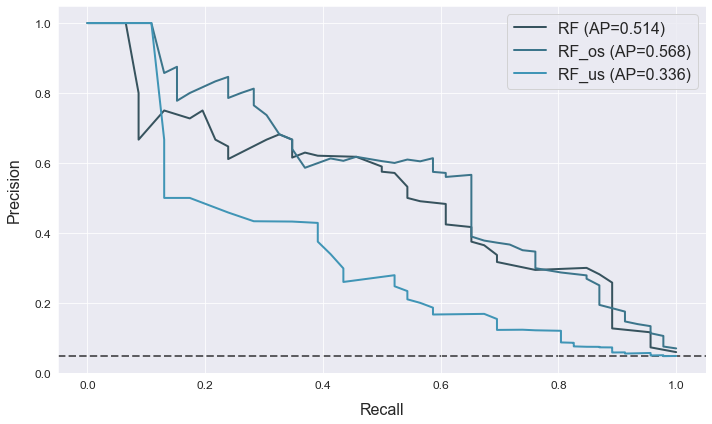

In [18]:
atom.plot_prc()

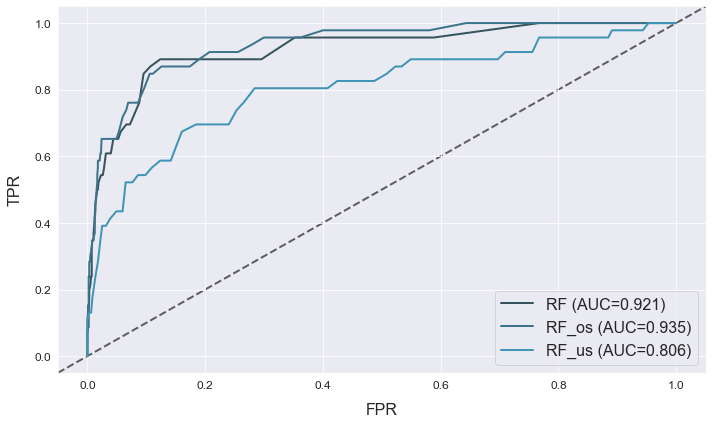

In [19]:
atom.plot_roc()